# Setup

In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.1 MB/s eta 0:00:00


In [ ]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy

In [ ]:
random.seed(2022)
np.random.seed(2022)

In [ ]:
!pip install pycairo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycairo-1.23.0.tar.gz (344 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pycairo (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pycairo
Failed to build pycairo
ERROR: Could not build wheels for pycairo, which is required to install pyproject.toml-based projects


In [ ]:
import cairo

# Question 9

In [ ]:
# build a graph: (Only December)
    # nodes correspond to locations
    # undirected weighted edges correspond to mean traveling times between each pair of locations
    # add the centroid coord of each polygon region (2-D vector) as an attrbute to the corresponding vertex

    # remove isolated nodes and few small connected components
    # keep the largest connected omponents
    # merge diplicate edges by averaging their weights

In [ ]:
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [ ]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [ ]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)  

In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

2716 1692450


In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
print(len(g.vs), len(g.es))
num_nodes = len(g.vs)
num_edges = len(g.es)
print("Number of nodes: " + str(num_nodes))
print("Number of edges: " + str(num_edges))

2649 1003858
Number of nodes: 2649
Number of edges: 1003858


# Question 10

In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
edf = mst.get_edge_dataframe()
edf.head()

,source,target,weight
edge ID,,,
0,0,2,129.765
1,0,13,123.790
2,1,2,90.235
3,1,3,126.475
4,1,9,125.675


In [ ]:
g.vs.attribute_names() # vertex

['display_name', 'coordinates']

In [ ]:
g.es.attribute_names() #edge

['weight']

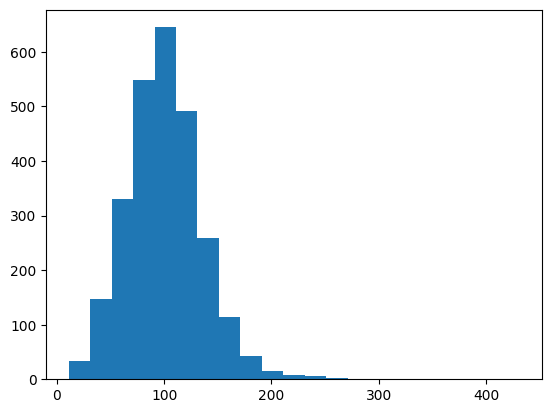

In [ ]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

In [ ]:
for i, e in enumerate(mst.es):
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    if i > 10:
        break

Distance in miles: 0.885
Time taken: 129.8
---------

Distance in miles: 0.570
Time taken: 123.8
---------

Distance in miles: 0.447
Time taken: 90.2
---------

Distance in miles: 0.621
Time taken: 126.5
---------

Distance in miles: 0.812
Time taken: 125.7
---------

Distance in miles: 0.618
Time taken: 119.9
---------

Distance in miles: 0.936
Time taken: 125.2
---------

Distance in miles: 1.026
Time taken: 117.3
---------

Distance in miles: 0.412
Time taken: 91.8
---------

Distance in miles: 0.256
Time taken: 64.8
---------

Distance in miles: 0.204
Time taken: 87.1
---------

Distance in miles: 0.620
Time taken: 110.9
---------



In [ ]:
for i, e in enumerate(mst.es):
  print("Source: " + str(mst.vs[e.source]['coordinates']))
  print("Target: " + str(mst.vs[e.target]['coordinates']))
  if i > 10:
    break

Source: [-118.12053321   34.10309557]
Target: [-118.13138209   34.09626386]
Source: [-118.12053321   34.10309557]
Target: [-118.11656383   34.09585388]
Source: [-118.13785063   34.09645121]
Target: [-118.13138209   34.09626386]
Source: [-118.13785063   34.09645121]
Target: [-118.13224544   34.10349303]
Source: [-118.13785063   34.09645121]
Target: [-118.14184446   34.08538654]
Source: [-118.13138209   34.09626386]
Target: [-118.12911933   34.08759475]
Source: [-118.13224544   34.10349303]
Target: [-118.14492317   34.0986815 ]
Source: [-118.13224544   34.10349303]
Target: [-118.14554175   34.11014686]
Source: [-118.14492317   34.0986815 ]
Target: [-118.15023891   34.09595766]
Source: [-118.1528085   34.098628 ]
Target: [-118.15023891   34.09595766]
Source: [-118.1528085   34.098628 ]
Target: [-118.1557638   34.0986163]
Source: [-118.1528085   34.098628 ]
Target: [-118.15508201   34.10732695]


# Question 11

In [ ]:
def is_triangle(sides):
    #write code here 
    sides = sorted(sides)

    if sides[0]+sides[1]>=sides[2] and all(s>0 for s in sides):
      return True
    
    return False

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

Test: False True


In [ ]:
def sample_triangles(g, n_samples):
    result = list()
    #result will have tuple of the the vertices of a triangle 

    combination = set()

    i = 0
    while i < n_samples:
        currentVertex = ()
        while True:
            index = set()
            
            while len(index) < 3:
                index.add(random.randint(0, len(g.vs()) - 1))
            tempIndex = list(index)
            tempIndex.sort()
            currentVertex = tuple(tempIndex)
            
            if not currentVertex in combination:
                combination.add(currentVertex)
                break
        i += 1
    combination = list(combination)
    
    for vertices in combination:
        resultTemp = g.vs()[vertices[0]], g.vs()[vertices[1]], g.vs()[vertices[2]]
        result.append(resultTemp)

    #result will have tuple of the the vertices of a triangle 

    return result

In [ ]:
n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
triangles = 0
sampled = sample_triangles(g, n_samples)

In [ ]:
for triangle_vs in sampled:
    
    edge_lengths = []
    
    for i in range(3):
        for j in range(i):
            edge_lengths.append(min(g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']))   
            
    triangles += is_triangle(edge_lengths)
    
print('Triangle inequality holds by {}%'.format(round(100.0 * triangles / n_samples, 1)))

# Question 12

In [70]:
!pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.0 MB/s eta 0:00:00


#Helper

## TSP Approximation

### Actual Data

In [ ]:
tsp = #refer to slides 
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

In [ ]:
hop_distances = ##refer to slides 
print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances.tolist()]))

### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])

<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
tsp_cost = 0
for i in range(len(tsp)):
    if i % 100 == 0:
        print(i)
        
    #write code 

In [ ]:
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

---
TSP results should resemble the following figure

In [ ]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

### Triangulation

In [ ]:
tri = #use the Delaunay function imported above 

In [ ]:
plt.figure(figsize=(15,15))
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.show()

In [ ]:
edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        #add the edges to edges_to_induce


In [ ]:
tri_g = g.subgraph_edges(edges_to_induce)